# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [9]:
from maddpg_agent import MADDPGAgent
import time
agent = MADDPGAgent(num_agents, state_size, action_size, random_seed=47, batch_size=256, buffer_size=int(1e6), use_batch_norm=True)
episode_scores = []
best_score=0.
start_time = time.time()
for i in range(5000):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    agent.reset_noise()
    game_time = 0
    while True:
        # states[0] is the observation of agent 0 and states[1] is the observation of agent 1
        # actions[0] is the action chosen by agent 0 and actions[1] is the action chosen by agent 1
        # selection of action is always based only on the observation
        actions = agent.act(states)

        # Apply these actions to the environment and receive the next state, rewards, and doneness
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        
        #print("actions: {} rewards: {}".format(actions, rewards))
        
        dones = env_info.local_done
        
        # Send in these two states, actions, next_states, and dones into the agent
        agent.step(states,actions,rewards,next_states, dones)
        scores += np.array(env_info.rewards)
        states = next_states
        if np.any(dones):
            break
        game_time += 1
    
    mean_last_10 = 0.
    mean_last_100 = 0.
    episode_scores.append(np.max(scores))

    if i >= 10:
        mean_last_10 = np.mean(episode_scores[i-10:i])
        if i>= 100:
            mean_last_100 = np.mean(episode_scores[i-100:i])
            if mean_last_100 >= 0.5:
                print("\nSolved in {} episodes with mean score: {:.4f}".format(i, mean_last_100))
                break
    elapsed_time = int(time.time() - start_time)
    sfmt = "\rEpisode {:4d} Score {:.2f} Mean Last 10 {:.4f} Mean Last 100 {:.4f} Elapsed {:6d}".format(i,
                                                                                  np.max(scores),
                                                                                  mean_last_10,
                                                                                  mean_last_100,
                                                                                  elapsed_time)
    print(sfmt, end="")
    if i%100 == 0 and i>0:
        print(sfmt)




Episode  100 Score 0.00 Mean Last 10 0.0000 Mean Last 100 0.0020 Elapsed     41
Episode  200 Score 0.00 Mean Last 10 0.0000 Mean Last 100 0.0020 Elapsed     90
Episode  300 Score 0.00 Mean Last 10 0.0000 Mean Last 100 0.0099 Elapsed    146
Episode  400 Score 0.00 Mean Last 10 0.0000 Mean Last 100 0.0080 Elapsed    199
Episode  500 Score 0.00 Mean Last 10 0.0200 Mean Last 100 0.0218 Elapsed    267
Episode  600 Score 0.00 Mean Last 10 0.0270 Mean Last 100 0.0311 Elapsed    335
Episode  700 Score 0.00 Mean Last 10 0.0200 Mean Last 100 0.0154 Elapsed    395
Episode  800 Score 0.10 Mean Last 10 0.0000 Mean Last 100 0.0284 Elapsed    465
Episode  900 Score 0.00 Mean Last 10 0.0480 Mean Last 100 0.0384 Elapsed    541
Episode 1000 Score 0.19 Mean Last 10 0.0480 Mean Last 100 0.0469 Elapsed    622
Episode 1100 Score 0.10 Mean Last 10 0.0680 Mean Last 100 0.0565 Elapsed    708
Episode 1200 Score 0.10 Mean Last 10 0.0790 Mean Last 100 0.0755 Elapsed    809
Episode 1300 Score 0.10 Mean Last 10 0.0

In [10]:
import pickle as pkl

In [11]:
pkl.dump(episode_scores, open("episode_scores.pkl", "wb"))

In [12]:
import torch
torch.save(agent.agents[0].actor_local.state_dict(),open("actor_local0.pt","wb"))
torch.save(agent.agents[1].actor_local.state_dict(), open("actor_local1.pt","wb"))
torch.save(agent.agents[0].critic_local.state_dict(),open("critic_local0.pt","wb"))
torch.save(agent.agents[1].critic_local.state_dict(), open("critic_local1.pt","wb"))

In [8]:
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [9]:
episode_scores = pkl.load(open("episode_scores.pkl","rb"))
means = [np.mean(episode_scores[max(i-100,0):i+1]) for i in range(len(episode_scores))]
d = {'raw scores':episode_scores, 'smoothed x100 scores':means}
pdf = pd.DataFrame(d)
print("Smoothed Score exceeded 0.5 at {}".format(pdf.index[pdf['smoothed x100 scores'] >= 0.5][0]))

Smoothed Score exceeded 0.5 at 3240


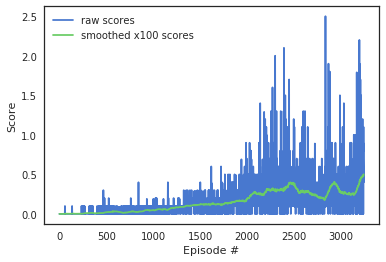

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
ax = pdf.plot() 
fig = ax.get_figure()
plt.ylabel('Score')
plt.xlabel('Episode #')
fig.savefig('fig.png')
